In [5]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import time
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap as cmap
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM


plt.rcParams.update(mpl.rcParamsDefault)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.facecolor'] = 'f4f4f4'
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['lines.linewidth'] = 2
pd.options.display.max_rows = 10

%config InlineBackend.figure_format = 'retina'

In [6]:
def retrieve(code, label):
    url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=' + code
    df = pd.read_csv(url, index_col=0, parse_dates=True)
    df.columns, df.index.name = [label], None
    all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.replace('.', None).reindex(all_dates).fillna(method='ffill')
    return df.astype('float')

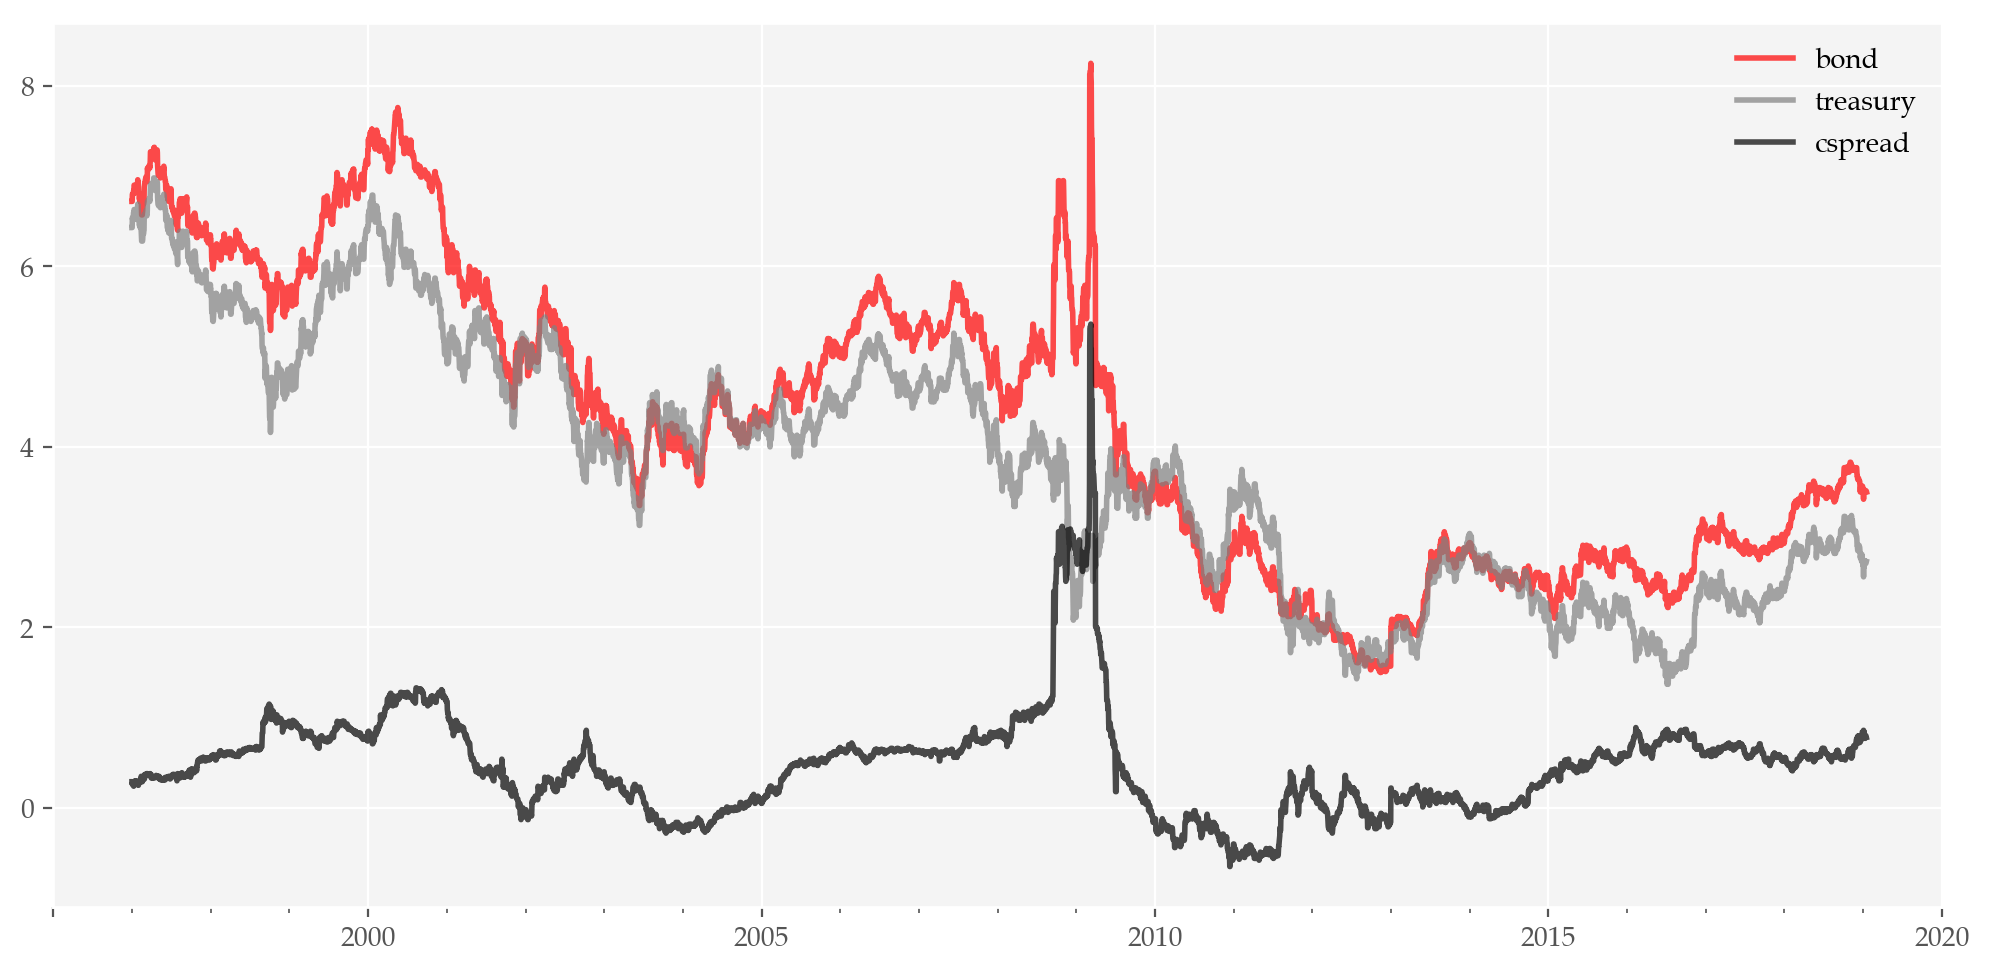

,bond,treasury,cspread,X_bond,X_treasury,y
1997-02-21,6.69,6.36,0.33,6.69,6.38,0.33
1997-02-22,6.69,6.36,0.33,6.69,6.36,0.33
1997-02-23,6.69,6.36,0.33,6.69,6.36,0.33
1997-02-24,6.71,6.39,0.32,6.69,6.36,0.32
1997-02-25,6.72,6.40,0.32,6.71,6.39,0.32
...,...,...,...,...,...,...
2019-01-12,3.50,2.71,0.79,3.50,2.71,0.79
2019-01-13,3.50,2.71,0.79,3.50,2.71,0.79
2019-01-14,3.51,2.71,0.80,3.50,2.71,0.80
2019-01-15,3.51,2.72,0.79,3.51,2.71,0.79


In [7]:
bond = retrieve('BAMLC0A1CAAAEY', 'bond')
treasury = retrieve('DGS10', 'treasury')

df = bond.join(treasury)
df['cspread'] = df['bond'] - df['treasury']
fig = plt.figure()
ax = fig.add_subplot(111)
df.plot(ax=ax, alpha=.7, colormap=cmap(['r', 'grey', 'k']))
plt.tight_layout()
plt.legend(frameon=False)
plt.xlim(pd.datetime(df.index.min().year, 1, 1), pd.datetime(df.index.max().year + 1, 1, 1))
plt.show()

df['X_bond'] = df['bond'].shift()
df['X_treasury'] = df['treasury'].shift()
df['y'] = df['cspread']
maxlen = 8000
df = df.dropna().iloc[-maxlen:, :]
df

In [8]:
X = df[[col for col in df.columns if col[:2] == 'X_']].values
X = X.reshape(X.shape[0], 1, X.shape[1])
y = df['y'].values

trained = True
batch_size = 10
epochs = 100
neurons = 4
val_split = .2

if trained:
    model = load_model('model.h5')
    history = pkl.load(open('history.pkl', 'rb'))
else:
    model = Sequential()
    model.add(LSTM(neurons, stateful=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adadelta')
    history = {'loss': [], 'val_loss': [], 'r2': [], 'val_r2': []}
    t0 = time.time()
    width = 20
    rightarrow, blacksquare, whitesquare = '>', '#', '='
    i = 0
    while i < epochs:
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_split=val_split)
        loss = model.history.history['loss'][0]
        val_loss = model.history.history['val_loss'][0]
        yhat = model.predict(X, batch_size=batch_size)
        if (np.isnan(loss) or np.isnan(val_loss)) or np.isnan(yhat[-1]):
            for layer in model.layers: 
                if hasattr(layer, 'kernel_initializer') and hasattr('layer', 'kernel'):
                    layer.kernel.initializer.run(session=K.get_session())
            history = {'loss': [], 'val_loss': []}
            i = 0
            continue
        val_size = round(len(y) * val_split)
        r2 = r2_score(y[:-val_size], yhat[:-val_size])
        val_r2 = r2_score(y[-val_size:], yhat[-val_size:])
        dt = time.time() - t0
        progress = (i + 1) / epochs
        eta = dt / progress * (1 - progress)
        nbars = round(width * progress)
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['r2'].append(r2)
        history['val_r2'].append(val_r2)
        msg = 'Epoch {}/{} |{}{}{}| - eta: {:.0f}s - loss: {:.4f} - val_loss: {:.4f} - r2: {:.4f} - val_r2: {:.4f}'.\
        format(i + 1, epochs, blacksquare * nbars, rightarrow, whitesquare * (width - nbars - 1),
               eta, loss, val_loss, r2, val_r2)
        print('{: <100s}'.format(msg), end='\r')
        i += 1
    print(msg.replace(rightarrow, blacksquare))
    model.save('model.h5')
    pkl.dump(history, open('history.pkl', 'wb'))

df['yhat'] = model.predict(X, batch_size=batch_size)
df

,bond,treasury,cspread,X_bond,X_treasury,y,yhat
1997-02-21,6.69,6.36,0.33,6.69,6.38,0.33,1.402724
1997-02-22,6.69,6.36,0.33,6.69,6.36,0.33,1.418332
1997-02-23,6.69,6.36,0.33,6.69,6.36,0.33,1.418332
1997-02-24,6.71,6.39,0.32,6.69,6.36,0.32,1.418332
1997-02-25,6.72,6.40,0.32,6.71,6.39,0.32,1.409767
...,...,...,...,...,...,...,...
2019-01-12,3.50,2.71,0.79,3.50,2.71,0.79,0.741949
2019-01-13,3.50,2.71,0.79,3.50,2.71,0.79,0.739391
2019-01-14,3.51,2.71,0.80,3.50,2.71,0.80,0.732125
2019-01-15,3.51,2.72,0.79,3.51,2.71,0.79,0.749891


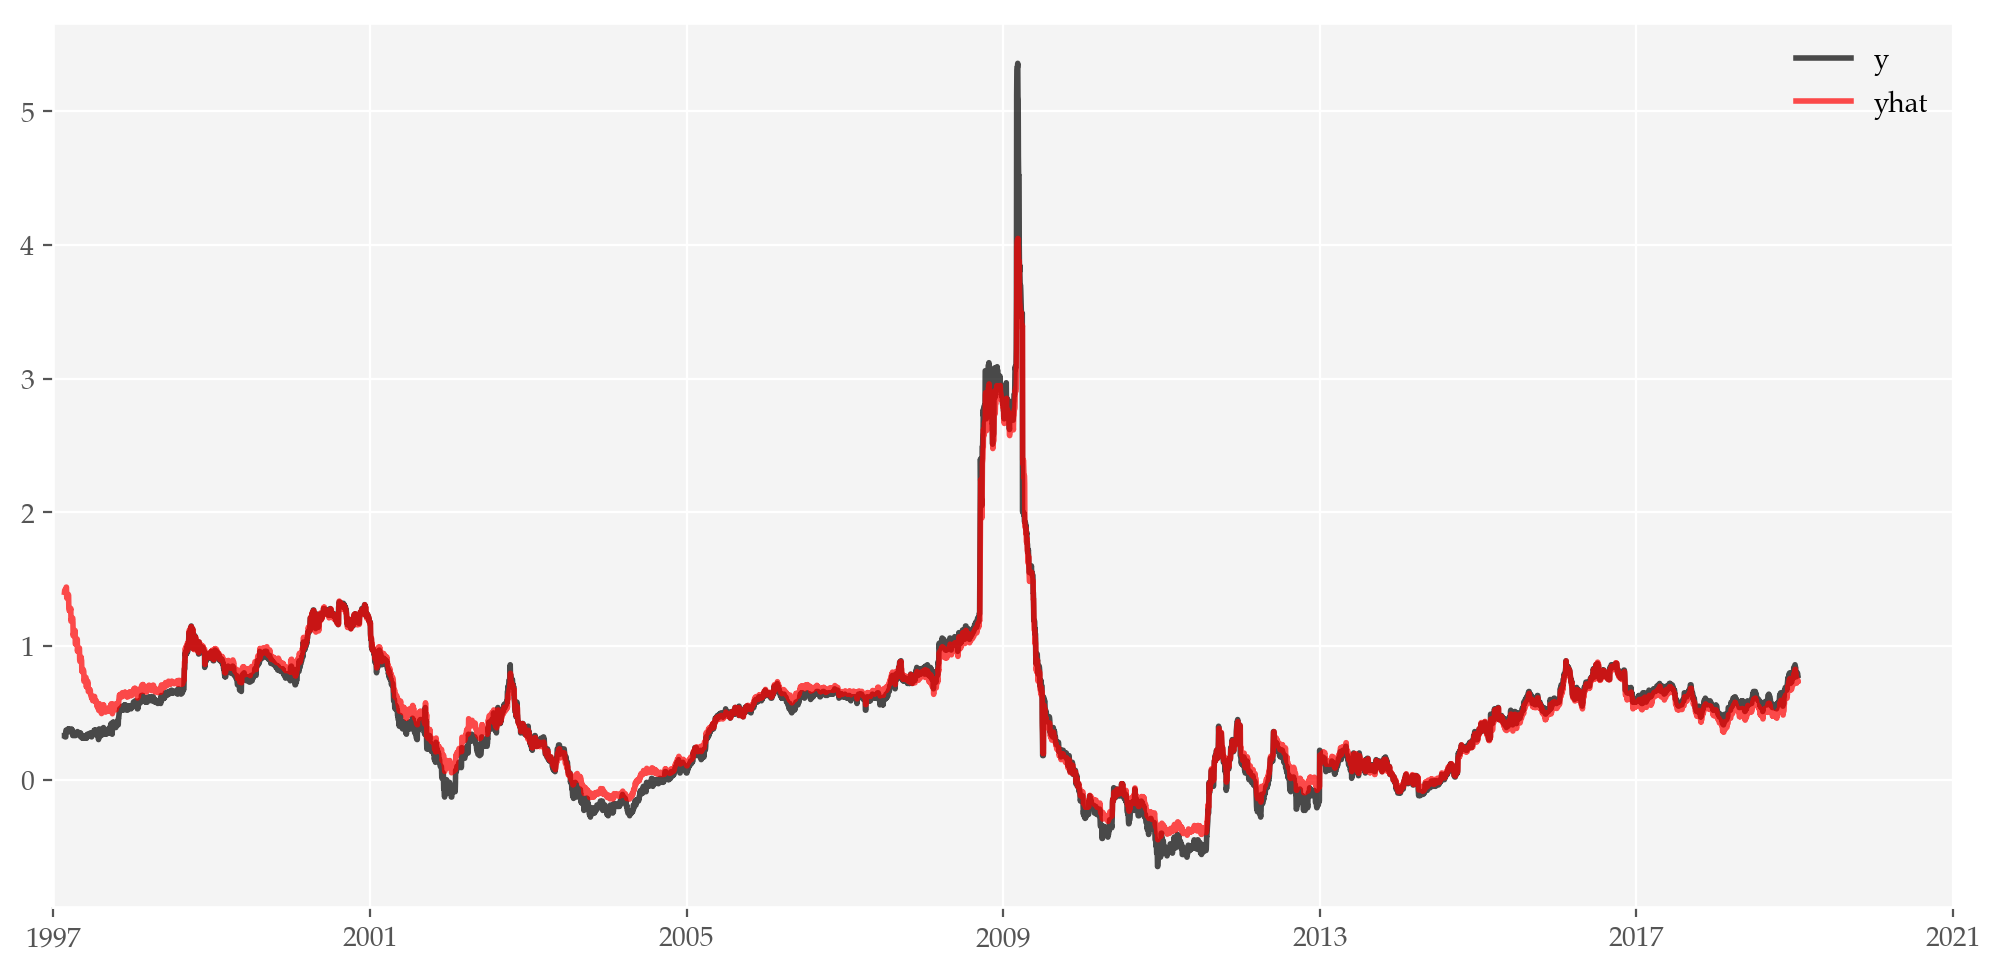

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df.index, df['y'], color='k', alpha=.7)
ax.plot(df.index, df['yhat'], color='r', alpha=.7)
plt.tight_layout()
plt.xlim(pd.datetime(df.index.min().year, 1, 1),
         pd.datetime(df.index.max().year + 2, 1, 1))
plt.legend(frameon=False)
plt.show()

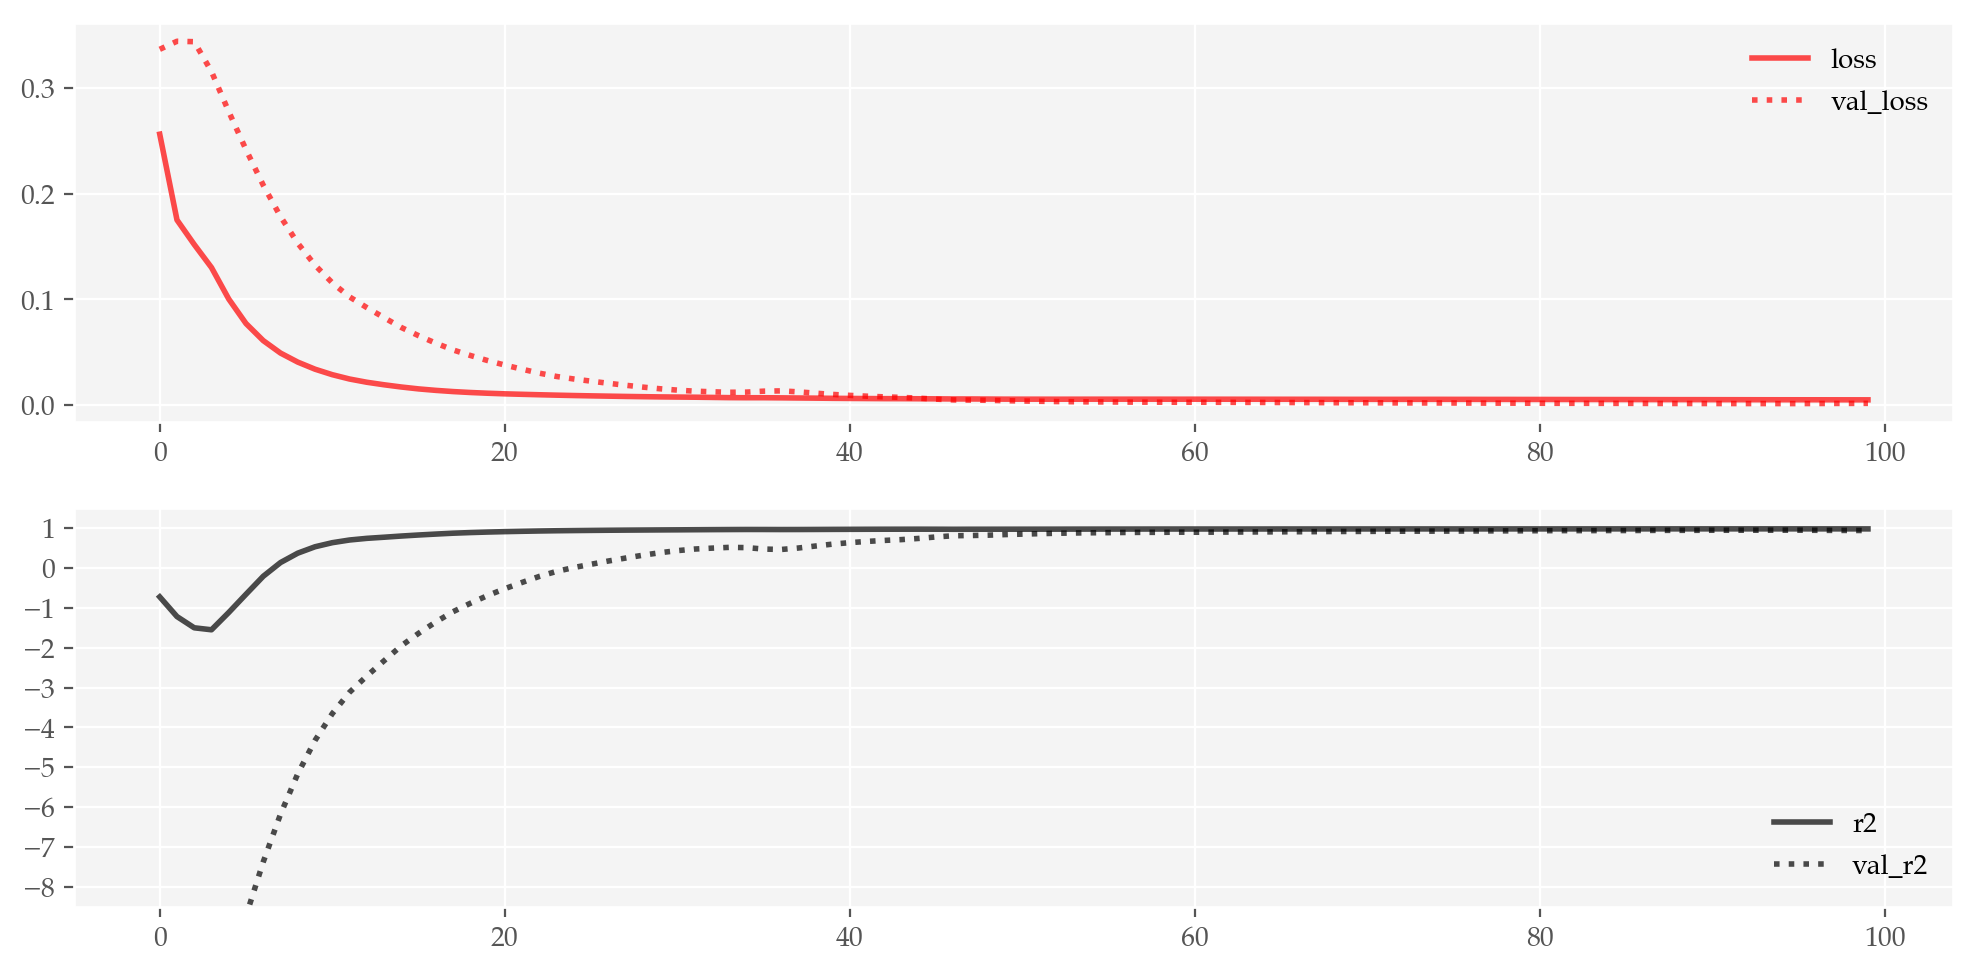

In [10]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(history['loss'], 'r', alpha=.7, label='loss')
ax.plot(history['val_loss'], 'r:', alpha=.7, label='val_loss')
ax.legend(frameon=False)
ax = fig.add_subplot(212)
ax.plot(history['r2'], 'k', alpha=.7, label='r2')
ax.plot(history['val_r2'], 'k:', alpha=.7, label='val_r2')
ax.set_yticks(np.arange(-8, 2, 1.))
ax.set_ylim(-8.5, 1.5)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

Click [here](https://github.com/allenfrostline/iaqf2019/blob/master/explore.ipynb) to download this notebook.